In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import ml_util as util


In [2]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df_full = pd.concat([training, test])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

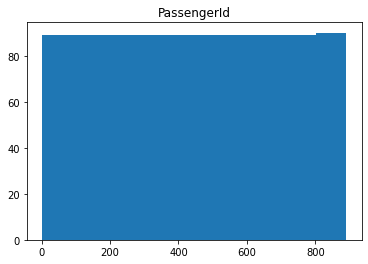

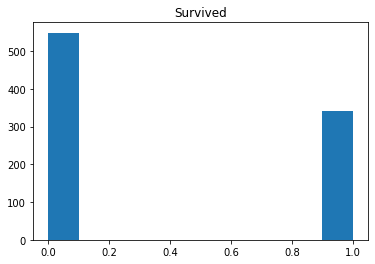

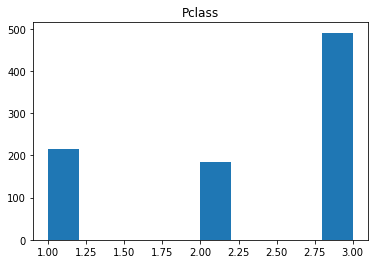

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


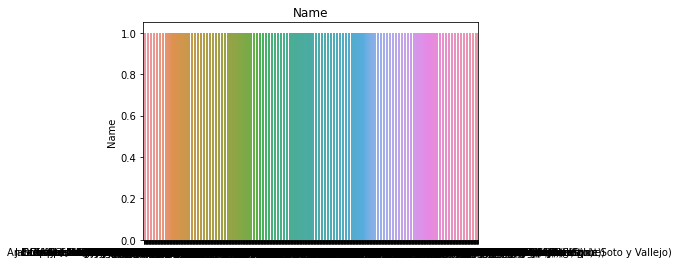

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


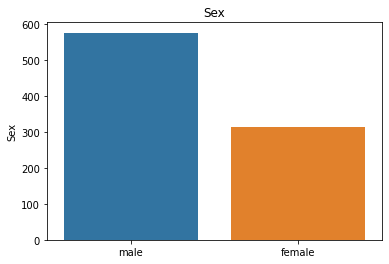

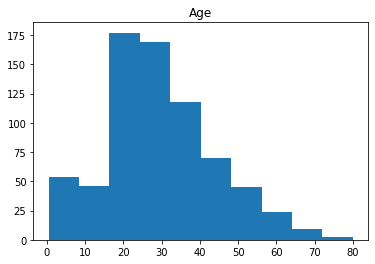

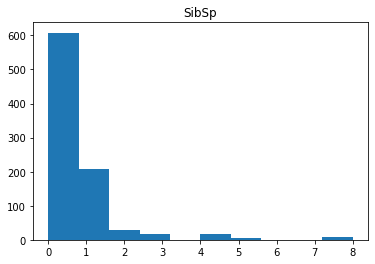

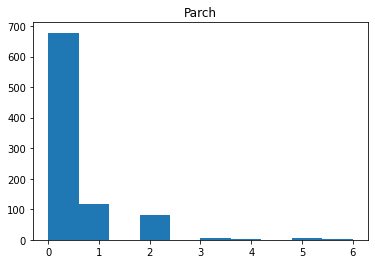

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


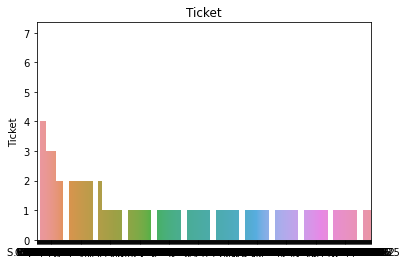

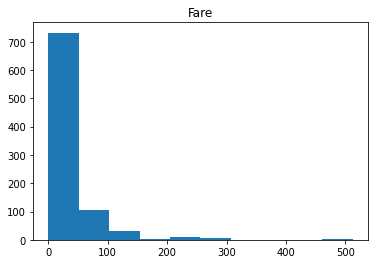

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


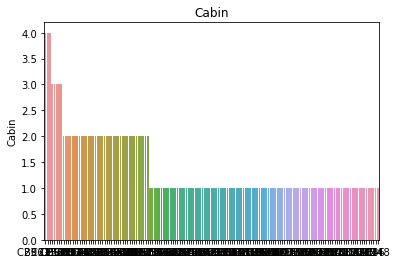

/home/hamhams/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


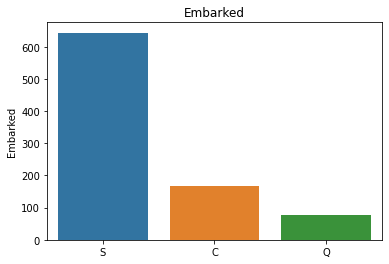

In [3]:

util.understanding(training)

In [4]:
print(training.Name.value_counts())
training['Sur'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

common_sur = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev']
training.Sur = training.Sur.apply(lambda x: 'Other' if x not in common_sur else x)
training.Sur.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64


Mr        517
Miss      182
Mrs       125
Master     40
Other      14
Dr          7
Rev         6
Name: Sur, dtype: int64

In [5]:
training.Sex = training.Sex.apply(lambda x: 0 if x == 'male' else 1)
training.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [6]:
print(training.Age.value_counts())
m_mean = round((training[training.Sex == 0].Age.mean()), 2)
f_mean = round((training[training.Sex == 1].Age.mean()), 2)
print(m_mean)
print(f_mean)

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64
30.73
27.92


In [7]:
training.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [8]:
training.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [11]:
training.Ticket.value_counts()
training.Ticket_grouped = training.Ticket.apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0].lower() if len(x.replace('.', '').replace('/', '').split(' ')) > 1 else '0')
#print(training.Ticket_grouped.value_counts())
training.Ticket_grouped = training.Ticket_grouped.apply(lambda x: 0 if x == '0' else 1)
print(training.Ticket_grouped.value_counts())

0    665
1    226
Name: Ticket, dtype: int64


In [12]:
training.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

In [15]:
training.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [16]:
training.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64